<a href="https://colab.research.google.com/github/JayaSurya3/Sudoku-GUI-Solver/blob/master/RiseDiseaseaDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import glob
import json
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

import sklearn
from sklearn.model_selection import train_test_split

In [3]:
BATCH_SIZE=32
HEIGHT=360
WIDTH=360

In [4]:
train_df = pd.DataFrame(columns=['directory','label'])

In [5]:
for i in os.listdir('/content/drive/MyDrive/rice_leaf_diseases'):
    for j in os.listdir('/content/drive/MyDrive/rice_leaf_diseases'+'/'+i+'/'):
        train_df = train_df.append({'directory':'/content/drive/MyDrive/rice_leaf_diseases'+'/'+i+'/'+j,'label':i},ignore_index=True)

In [6]:
train_df.shape

(120, 2)

In [7]:
train_df

,directory,label
0,/content/drive/MyDrive/rice_leaf_diseases/Heal...,Healthy
1,/content/drive/MyDrive/rice_leaf_diseases/Heal...,Healthy
2,/content/drive/MyDrive/rice_leaf_diseases/Heal...,Healthy
3,/content/drive/MyDrive/rice_leaf_diseases/Heal...,Healthy
4,/content/drive/MyDrive/rice_leaf_diseases/Heal...,Healthy
...,...,...
115,/content/drive/MyDrive/rice_leaf_diseases/Brow...,Brownspot
116,/content/drive/MyDrive/rice_leaf_diseases/Brow...,Brownspot
117,/content/drive/MyDrive/rice_leaf_diseases/Brow...,Brownspot
118,/content/drive/MyDrive/rice_leaf_diseases/Brow...,Brownspot


In [8]:
train_df.replace({'leaf_blast': 'LeafBlast', 'Brown spot': 'BrownSpot'},inplace=True)

In [9]:
dic={}
for i in range(len(train_df.label.unique())):
    dic[train_df.label.unique()[i]] = np.float16(i)
key_list = list(dic.keys())
val_list = list(dic.values())
train_df.replace(dic,inplace=True)
train_df

,directory,label
0,/content/drive/MyDrive/rice_leaf_diseases/Heal...,0.0
1,/content/drive/MyDrive/rice_leaf_diseases/Heal...,0.0
2,/content/drive/MyDrive/rice_leaf_diseases/Heal...,0.0
3,/content/drive/MyDrive/rice_leaf_diseases/Heal...,0.0
4,/content/drive/MyDrive/rice_leaf_diseases/Heal...,0.0
...,...,...
115,/content/drive/MyDrive/rice_leaf_diseases/Brow...,2.0
116,/content/drive/MyDrive/rice_leaf_diseases/Brow...,2.0
117,/content/drive/MyDrive/rice_leaf_diseases/Brow...,2.0
118,/content/drive/MyDrive/rice_leaf_diseases/Brow...,2.0


In [10]:
X= train_df['directory']
y= train_df['label']
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,shuffle=True)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(90,) (90,) (30,) (30,)


In [11]:
def load_images(files):
    images=[]
    for i in files:
        a = Image.open(i)
        a = a.resize((HEIGHT,WIDTH))
        a = np.asarray(a)
#         a = a/255.0
        images.append(a)
    return np.array(images)

In [12]:
def DataGen(data,label,bsize=BATCH_SIZE):
    while True:
        for i in range(len(data)):
#             rand = np.random.randint(0,len(data)-BATCH_SIZE)
            images = load_images(data[i:i+BATCH_SIZE])
            labels = label[i:i+BATCH_SIZE]
            yield np.array(images),np.array(labels)

In [13]:
train_dataset = DataGen(X_train,y_train)
valid_dataset = DataGen(X_test,y_test)
a,b = next(train_dataset)
c,d = next(valid_dataset)
print(a.shape,b.shape,c.shape,d.shape)

(32, 360, 360, 3) (32,) (30, 360, 360, 3) (30,)


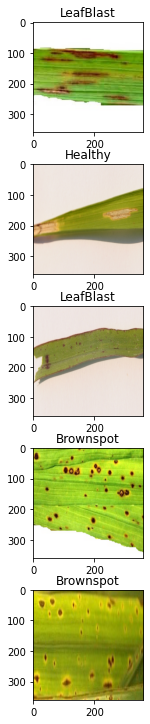

In [14]:
def sample_plot(image,label):
    fig, axs = plt.subplots(5, 1, figsize=(10,10))
    fig.tight_layout()
    for i in range(5):
        
        axs[i].imshow(image[i])
        axs[i].set_title(key_list[val_list.index(label[i])])
        
#         axs[i,1].imshow(masks[i])
#         axs[i,1].set_title('Mask')
        
    plt.show()
sample_plot(a,b)

In [15]:
inputs = tf.keras.layers.Input((HEIGHT,WIDTH,3))
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
])(inputs)
    
base_model = tf.keras.applications.efficientnet.EfficientNetB1(include_top=False, weights='imagenet',pooling='max')
base_model.trainable=True
x = base_model(data_augmentation,training=True)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(dic), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])#,tf.keras.metrics.AUC()])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 360, 360, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 360, 360, 3)       0         
                                                                 
 efficientnetb1 (Functional)  (None, 1280)             6575239   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 16)                20496     
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 6,595,786
Trainable params: 6,533,731
Non-train

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('baseline_model.hdf5', monitor='val_sparse_categorical_crossentropy', verbose=1, save_best_only=True, mode='max')
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_crossentropy',patience=3,verbose=1,factor=0.5,min_lr=1e-5)
TRAIN_STEPS = 100
VAL_STEPS = 25
EPOCHS = 5
history = model.fit(train_dataset, steps_per_epoch=TRAIN_STEPS,validation_data=(valid_dataset),validation_steps=VAL_STEPS,
                    batch_size=BATCH_SIZE,epochs=EPOCHS, callbacks = checkpoint)

1/1 [==============================] - 0s 336ms/step


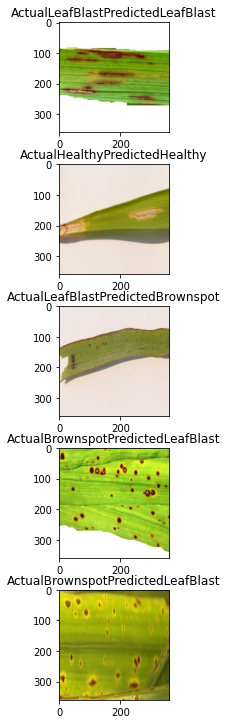

In [18]:
def test_plot(image,label):
    fig, axs = plt.subplots(5, 1, figsize=(10,10))
    fig.tight_layout()
    for i in range(5):
        y_pred = model.predict(np.reshape(image[i],(1,HEIGHT,WIDTH,3)))
        y_pred_l = np.argmax(y_pred)
        
#         y_pred_l= 'Real' if y_pred==0.0 else 'Fake'
#         y_true_l = 'Real' if label[i]==0.0 else 'Fake'
        axs[i].imshow(image[i])
        axs[i].set_title('Actual'+str(key_list[val_list.index(label[i])])+'Predicted'+key_list[val_list.index(y_pred_l)])
        
#         axs[i,1].imshow(masks[i])
#         axs[i,1].set_title('Mask')
        
    plt.show()
test_plot(a,b)

In [19]:
model.save('baseline_final.hdf5')